<a id="title_ID"></a>
# Beginner: Read and Plot A TESS Data Validation Timeseries File

This notebook tutorial demonstrates how to load and plot the contents of a TESS data validation timeseries (dvt) file.  We will plot the flux timeseries contained within the file.

In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

## Introduction

TESS does a search of the postage-stamp, two-minute cadence data. For every signal it identifies with its Transit Planet Search (TPS) module, it creates something called a Threshold Crossing Event (TCE).  TCEs are periodic signals that exceed a nominal signal-to-noise requirement. Some are consistent with transiting planets, others are eclipsing binaries, and others are more consistent with variable stars or noise in the data. 

The Data Validation (DV) module of the pipeline produces a set of products that can help validate the quality of a TCE. The DV products include a time series file of the flattened light curve that was searched and relevant statistics for each signal (dvt.fits), DV reports that consists of a few diagnostic plots and relevant statistics (dvs.pdf for individual signals, dvr.pdf for all signals found in the TIC object), and an xml file (dvr.xml) that contains the results of the planet transit fit.  We will be exploring a dvt.fits file in this tutorial.

This tutorial will refer to a couple TESS-related terms that we define here.
* Sector = TESS observed the sky in regions of 24x96 degrees along the southern, then northern, ecliptic hemispheres.  Each of these regions is referred to as a "sector", starting with Sector 1.
* HDU = Header Data Unit.  A FITS file is made up of HDUs that contain data and metadata relating to the file. The first HDU is called the primary HDU, and anything that follows is considered an "extension", e.g., "the first FITS extension", "the second FITS extension", etc.
* BJD = Barycentric Julian Date, the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System center of mass.
* TBJD = TESS Barycentric Julian Date, the timestamp measured in BJD, but offset by 2457000.0.  I.e., TBJD = BJD - 2457000.0
* Cadence = The interval between flux measurements, nominally ~2 minutes for the target pixel files, and ~30 minutes for the full frame images.
* TCE = Threshold Crossing Event, periodic signals found by the TESS pipeline that exceed a nominal signal-to-noise ratio.

## Obtaining The DVT Series File

We will read the data validation file of TIC 100100827 (known to have at least one planet, WASP-18 b) from Sector 2 using the MAST URL location.  So that we can get started with understanding the file contents without reviewing how to automatically search for and retrieve TESS files, we won't show how to search and retrieve TESS DVT files in this tutorial. Consult other TESS tutorials [in the TESS Archive Handbook](https://outerspace.stsci.edu/display/TESS/6.0+-+Data+Search+Tutorials) for much more information on how to search for TESS data using MAST services.

In [2]:
# For the purposes of this tutorial, we just know the MAST URL location of the file we want to examine.
dvt_file = "https://archive.stsci.edu/missions/tess/tid/s0002/0000/0001/0010/0827/tess2018235142541-s0002-s0002-0000000100100827-00109_dvt.fits"

## Understanding The DVT File Structure

The DVT FITS file consits of a primary HDU with metadata stored in the header, and one FITS extension HDU per TCE found in the lightcurve of the specified TIC ID.  These extensions contain the detrended flux time series phased to the orbital period of the signal, stored as a binary FITS table.  The last extension HDU always contains some additional statistics about the search, also stored in a binary FITS table.  Let's examine the structure of the FITS file using the astropy.fits `info` function, which shows the FITS file format in more detail.

In [3]:
fits.info(dvt_file)

Filename: /root/.astropy/cache/download/py3/124ac35a2c99549df3bba96cd314a11a
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  TCE_1         1 BinTableHDU     92   19737R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  TCE_2         1 BinTableHDU     92   19737R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  3  Statistics    1 BinTableHDU    157   19737R x 38C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In this case, TIC 100100827 has two TCE's identified, and the "statistics" extension in the last HDU, as expected.  Let's examine one of the TCE extensions in more detail using the astropy.fits `getdata` function and see what columns are available.

In [4]:
fits.getdata(dvt_file, ext=1).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PHASE'; format = 'E'; unit = 'days'; disp = 'E14.7'
    name = 'LC_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_INIT_ERR'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'LC_DETREND'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_INIT'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'MODEL_WHITE'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
)

In addition to the timestamps in TBJD format, there is a column containing the times phased to the orbital period of the signal, and there are several columns of fluxes.  LC_INIT is the "unwhitened" fluxes, LC_WHITE are the "whitened" fluxes.  The MODEL_INIT and MODEL_WHITE fluxes are the corresponding model fluxes based on the best fit to the signal.

## Plotting The Timeseries Fluxes.

Let's open the FITS file and extract some metadata from the headers, and also store some of the columns from the first TCE signal for use later when we plot the results.

In [5]:
with fits.open(dvt_file, mode="readonly") as hdulist:
    
    # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
    # and TESS magnitude.
    star_teff = hdulist[0].header['TEFF']
    star_logg = hdulist[0].header['LOGG']
    star_tmag = hdulist[0].header['TESSMAG']
    
    # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
    # extension.
    period = hdulist[1].header['TPERIOD']
    duration = hdulist[1].header['TDUR']
    epoch = hdulist[1].header['TEPOCH']
    depth = hdulist[1].header['TDEPTH']
    
    # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
    # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
    # model fluxes.
    times = hdulist[1].data['TIME']
    phases = hdulist[1].data['PHASE']
    fluxes_init = hdulist[1].data['LC_INIT']
    model_fluxes_init = hdulist[1].data['MODEL_INIT']

Let's make a plot of the detrended fluxes and model fluxes vs. orbital phase.

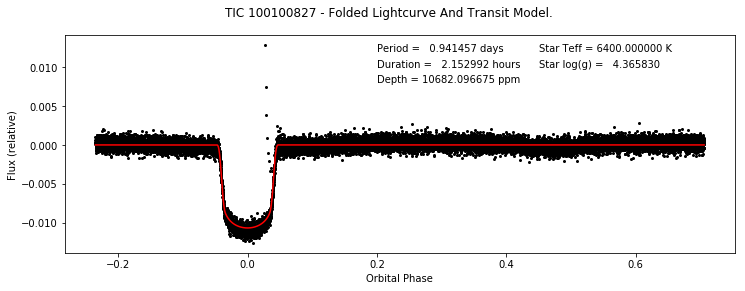

In [6]:
# First sort the phase and flux arrays by phase so we can draw the connecting lines between points.
sort_indexes = np.argsort(phases)

# Start figure and axis.
fig, ax = plt.subplots(figsize=(12,4))

# Plot the detrended fluxes as black circles.  We will plot them in sorted order.
ax.plot(phases[sort_indexes], fluxes_init[sort_indexes], 'ko',
       markersize=2)

# Plot the model fluxes as a red line.  We will plot them in sorted order so the line connects between points cleanly.
ax.plot(phases[sort_indexes], model_fluxes_init[sort_indexes], '-r')

# Let's label the axes and define a title for the figure.
fig.suptitle('TIC 100100827 - Folded Lightcurve And Transit Model.')
ax.set_ylabel("Flux (relative)")
ax.set_xlabel("Orbital Phase")

# Let's add some text in the top-right containing some of the fit parameters.
plt.text(0.2, 0.012, "Period = {0:10.6f} days".format(period))
plt.text(0.2, 0.010, "Duration = {0:10.6f} hours".format(duration))
plt.text(0.2, 0.008, "Depth = {0:10.6f} ppm".format(depth))
plt.text(0.45, 0.012, "Star Teff = {0:10.6f} K".format(star_teff))
plt.text(0.45, 0.010, "Star log(g) = {0:10.6f}".format(star_logg))

plt.show()

## Examining The Statistics Extension

The statistics extension HDU contains the Single Event Statistics ("SES") correlation time series and the SES normalization time series for each of the pipeline's search durations. For more information, see [Tenebaum et al. 2012, ApJS, 199, 24](http://adsabs.harvard.edu/abs/2012ApJS..199...24T) and [Twicken et al. 2018, PASP, 130, 6](http://adsabs.harvard.edu/abs/2018PASP..130f4502T) for a description of the DV statistics for Kepler - the TESS DV statistics are very similar. These statistics are used to calculate the Combined Differential Photometric Precision ("CDPP") time series ([Gilliland et al. 2011, ApJS, 197, 6](http://adsabs.harvard.edu/abs/2011ApJS..197....6G)).

In [7]:
fits.getdata(dvt_file, ext=3).columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'sigma'; disp = 'E14.7'
    name = 'RESIDUAL_LC'; format = 'E'; unit = 'dimensionless'; disp = 'E14.7'
    name = 'DEWEIGHTS'; format = 'E'; unit = 'proportion'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'SES_CORR_0_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_1_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_1_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_2_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_0'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_3_5'; format = 'E'; disp = 'E14.7'
    name = 'SES_CORR_4_5'; format = 'E'; disp = 'E14.7'


## About this Notebook

**Authors:** Susan E. Mullally, Scott W. Fleming

**Updated On:** 2018-11-29

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 